[32958, 49942, 52284, 35884, 29942]


<function matplotlib.pyplot.show(close=None, block=None)>

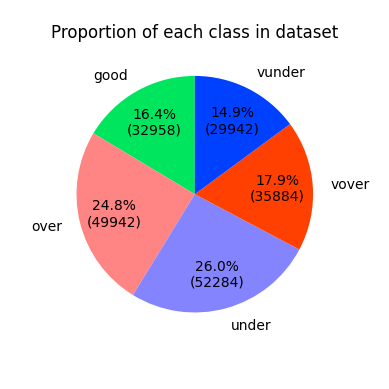

In [1]:
import os
import matplotlib.pyplot as plt

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{:.1f}%\n({v:d})'.format(pct, v=val)
    return my_format

dir_path1 = 'augmented_synth/train/'
dir_path2 = 'augmented_synth/test/'
labels = ['good', 'over', 'under', 'vover', 'vunder']
colours =['#00e55e','#ff8484','#8484ff','#ff4000','#0040ff']
counts = []
for label in labels:
    counts.append(len([entry for entry in os.listdir(dir_path1+label) if os.path.isfile(os.path.join(dir_path1+label, entry))]) + len([entry for entry in os.listdir(dir_path2+label) if os.path.isfile(os.path.join(dir_path2+label, entry))]))

print(counts)
plt.rcParams['axes.titley'] = 1.0
plt.rcParams['axes.titlepad'] = -20
plt.pie(counts, labels=labels, autopct=autopct_format(counts),colors=colours, radius=.8, pctdistance=.7, labeldistance=1.15, startangle=90)
plt.title("Proportion of each class in dataset")
plt.savefig("dataset_split.png",dpi=300)
plt.show

In [1]:
import random
import tensorflow as tf
import pathlib
import numpy as np
#from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow_addons as tfa



#Flattening nested model
def flatten_model(model_nested):
    layers_flat = []
    for layer in model_nested.layers:
        try:
            layers_flat.extend(layer.layers)
        except AttributeError:
            layers_flat.append(layer)
    model_flat = tf.keras.models.Sequential(layers_flat)
    return model_flat



#per fold metrics for cumulative average
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []
tp_per_fold = []
tn_per_fold = []
fp_per_fold = []
fn_per_fold = []


data_dir = pathlib.Path("synth_data/augmented_synth_line/train")

batch_size = 64
img_h = 224
img_w = 224
epochs = 1000
history = None


#split data into train test (not validation) 0.2
train_ds = tf.keras.utils.image_dataset_from_directory(
	data_dir,
	seed = 123,
	image_size=(img_h, img_w),
	batch_size=batch_size,
	label_mode='categorical',
    subset="training",
    validation_split=0.2)

val_ds = tf.keras.utils.image_dataset_from_directory(
	data_dir,
	seed = 123,
	image_size=(img_h, img_w),
	batch_size=batch_size,
	label_mode='categorical',
    subset="validation",
    validation_split=0.2)

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

class_num_training_samples = {}
for f in train_ds.file_paths:
    class_name = f.split('/')[-2]
    if class_name in class_num_training_samples:
        class_num_training_samples[class_name] += 1
    else:
        class_num_training_samples[class_name] = 1
max_class_samples = max(class_num_training_samples.values())
class_weights = {}
for i in range(0, len(train_ds.class_names)):
    class_weights[i] = max_class_samples/class_num_training_samples[train_ds.class_names[i]]

print(class_weights)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.15.0-dev20230906). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


ImportError: cannot import name 'Buffer' from 'typing_extensions' (/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/typing_extensions.py)

# NAS

In [ ]:
from tensorflow.keras import layers, Model 
import tensorflow as tf


chromosome = {'conv_filters': [[256, 256, 256, 64, 64], [32, 128, 32, 128, 32], [256, 64, 64, 32], [32]],
              'kernel_size': [[3, 7, 5, 7, 3], [5, 7, 9, 3, 9], [3, 7, 3, 9], [5]],
              'stride': [1, 2, 2, 1],
              'activation': [[tf.keras.activations.sigmoid, tf.keras.activations.linear, tf.keras.activations.sigmoid, tf.keras.activations.sigmoid, tf.keras.activations.sigmoid], [tf.keras.activations.linear, tf.keras.activations.relu, tf.keras.activations.relu, tf.keras.activations.linear, tf.keras.activations.sigmoid], [tf.keras.activations.linear, tf.keras.activations.linear, tf.keras.activations.sigmoid, tf.keras.activations.relu], [tf.keras.activations.relu]],
              'skip_connection': [False, False, False, True],
              'hidden_size': [256],
              'dropout_rate': [0.3],
              'learning_rate': 0.001,
              'optimizer': tf.keras.optimizers.SGD}

def create_conv_block(x_input, conv_filters, kernel_size, stride, activation, skip_connection):

    x = layers.Conv2D(conv_filters[0],
                          kernel_size=(kernel_size[0], kernel_size[0]),
                          strides=(stride, stride),
                          activation=activation[0],
                          padding='same')(x_input)
    x = layers.BatchNormalization()(x)

    for conv in range(1,len(conv_filters),1):
        x = layers.Conv2D(conv_filters[conv],
                          kernel_size=(kernel_size[conv], kernel_size[conv]),
                          strides=(1, 1),
                          activation=activation[conv],
                          padding='same')(x)
        x = layers.BatchNormalization()(x)

    if skip_connection:
        xx = layers.Conv2D(conv_filters[len(conv_filters)-1],
                          kernel_size=(1,1),
                          strides=(stride,stride),
                          activation=None,
                          padding='same')(x_input)
        x = layers.Add()([x,xx])
        return(x)
    else:
        return(x)

# Function to create the neural network model based on chromosome
def create_model(conv_filters, kernel_size, stride, activation, skip_connection, hidden_size, dropout_rate, learning_rate, optimizer):
    input_shape = (128,128,3)
    model_input = layers.Input(shape=input_shape)
    x = create_conv_block(x_input = model_input,  
                          conv_filters=conv_filters[0], 
                          kernel_size=kernel_size[0], 
                          stride=stride[0], 
                          activation=activation[0], 
                          skip_connection=skip_connection[0])
    for block_num in range(1,len(conv_filters),1):
        x = create_conv_block(x_input = x, 
                              conv_filters=conv_filters[block_num], 
                              kernel_size=kernel_size[block_num], 
                              stride=stride[block_num], 
                              activation=activation[block_num], 
                              skip_connection=skip_connection[block_num])
        x = layers.MaxPooling2D(padding='same')(x)

    x = layers.Flatten()(x)

    for d in range(len(hidden_size)):
        x = layers.Dense(hidden_size[d], activation='relu')(x)
        x = layers.Dropout(dropout_rate[d])(x)

    x = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=model_input, outputs=x)

    try:
        with tf.device("/GPU:0"):
            model.compile(
                optimizer=optimizer(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=["accuracy",
                        tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.TruePositives(),
                        tf.keras.metrics.TrueNegatives(),
                        tf.keras.metrics.FalsePositives(),
                        tf.keras.metrics.FalseNegatives()
                        ])
            
    except RuntimeError as e:
        print(e)


    print(model.summary())
    return model


def create_model_from_chromosome(chromosome):
    conv_filters = chromosome['conv_filters']
    kernel_size = chromosome['kernel_size']
    stride = chromosome['stride']
    activation = chromosome['activation']
    skip_connection = chromosome['skip_connection']
    hidden_size = chromosome['hidden_size']
    dropout_rate = chromosome['dropout_rate']
    learning_rate = chromosome['learning_rate']
    optimizer = chromosome['optimizer']
    
    model = create_model(conv_filters, kernel_size, stride, activation, skip_connection, hidden_size, dropout_rate, learning_rate, optimizer)
    return model

model = create_model_from_chromosome(chromosome)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=batch_size, callbacks=[es], class_weight=class_weights)

# VGG16

In [51]:

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers, Model


name = "vgg16"
inp = layers.Input((img_h,img_h,3))
x = VGG16(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inp, x)
try:
    with tf.device("/GPU:0"):
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=["accuracy",
                    tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()
                    ])
        #history = model.fit(data_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
        history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=64, callbacks=[es], class_weight=class_weights)
except RuntimeError as e:
    print(e)

Epoch 1/100
1988/1988 [==============================] - 93s 46ms/step - loss: 0.8745 - accuracy: 0.7029 - f1_score: 0.3308 - precision_3: 0.7486 - recall_3: 0.6530 - true_positives_3: 83070.0000 - true_negatives_3: 480918.0000 - false_positives_3: 27898.0000 - false_negatives_3: 44134.0000 - val_loss: 0.5144 - val_accuracy: 0.7799 - val_f1_score: 0.5103 - val_precision_3: 0.7841 - val_recall_3: 0.7700 - val_true_positives_3: 24486.0000 - val_true_negatives_3: 120462.0000 - val_false_positives_3: 6742.0000 - val_false_negatives_3: 7315.0000
Epoch 2/100
1988/1988 [==============================] - 94s 47ms/step - loss: 0.5797 - accuracy: 0.8011 - f1_score: 0.5300 - precision_3: 0.8045 - recall_3: 0.7950 - true_positives_3: 101132.0000 - true_negatives_3: 484237.0000 - false_positives_3: 24579.0000 - false_negatives_3: 26072.0000 - val_loss: 0.4346 - val_accuracy: 0.8181 - val_f1_score: 0.5517 - val_precision_3: 0.8199 - val_recall_3: 0.8152 - val_true_positives_3: 25924.0000 - val_true_

# VGG19 

In [38]:

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers, Model


name = "vgg19"
inp = layers.Input((img_h,img_h,3))
x = VGG19(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inp, x)
try:
    with tf.device("/GPU:0"):
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=["accuracy",
                    tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()
                    ])
        #history = model.fit(data_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
        history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=64, callbacks=[es])
except RuntimeError as e:
    print(e)

Epoch 1/100


2024-03-06 18:04:43.100693: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f25fc4adfa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-06 18:04:43.101150: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-06 18:04:43.151665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709748283.357543   33670 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1988/1988 [==============================] - 105s 52ms/step - loss: 0.6353 - accuracy: 0.7349 - f1_score: 0.3959 - precision: 0.7690 - recall: 0.6981 - true_positives: 88796.0000 - true_negatives: 482141.0000 - false_positives: 26675.0000 - false_negatives: 38408.0000 - val_loss: 0.4602 - val_accuracy: 0.8030 - val_f1_score: 0.5166 - val_precision: 0.8066 - val_recall: 0.7989 - val_true_positives: 25407.0000 - val_true_negatives: 121114.0000 - val_false_positives: 6090.0000 - val_false_negatives: 6394.0000
Epoch 2/100
1988/1988 [==============================] - 108s 54ms/step - loss: 0.4355 - accuracy: 0.8144 - f1_score: 0.5484 - precision: 0.8177 - recall: 0.8097 - true_positives: 102995.0000 - true_negatives: 485859.0000 - false_positives: 22957.0000 - false_negatives: 24209.0000 - val_loss: 0.4320 - val_accuracy: 0.8165 - val_f1_score: 0.5899 - val_precision: 0.8197 - val_recall: 0.8127 - val_true_positives: 25844.0000 - val_true_negatives: 121520.0000 - val_false_positives: 5684.0

# DenseNet201

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras import layers, Model


name = "DenseNet201"
inp = layers.Input((img_h,img_h,3))
x = DenseNet201(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(4, activation='softmax')(x)
model = Model(inp, x)
try:
    with tf.device("/GPU:0"):
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=["accuracy",
                    tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()
                    ])
        #history = model.fit(data_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
        history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
except RuntimeError as e:
    print(e)

# DenseNet169

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras import layers, Model


name = "DenseNet169"
inp = layers.Input((img_h,img_h,3))
x = DenseNet169(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(4, activation='softmax')(x)
model = Model(inp, x)
try:
    with tf.device("/GPU:0"):
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=["accuracy",
                    tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()
                    ])
        #history = model.fit(data_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
        history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
except RuntimeError as e:
    print(e)

# MobileNet V2

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers, Model


name = "MobileNetV2"
inp = layers.Input((img_h,img_h,3))
x = MobileNetV2(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(4, activation='softmax')(x)
model = Model(inp, x)
try:
    with tf.device("/GPU:0"):
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=["accuracy",
                    tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()
                    ])
        #history = model.fit(data_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
        history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])
except RuntimeError as e:
    print(e)

# MobileNet V3 Small

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, Model


name = "MobileNetV3Small"
inp = layers.Input((img_h,img_h,3))
x = MobileNetV3Small(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inp, x)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy",
            tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
            ]
)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])

# MobileNet V3 Large

In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, Model


name = "MobileNetV3Large"
inp = layers.Input((img_h,img_h,3))
x = MobileNetV3Large(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inp, x)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy",
            tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
            ]
)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32, callbacks=[es])

# ResNet50 V2

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras import layers, Model


name = "ResNet50V2"
inp = layers.Input((img_h,img_h,3))
x = ResNet50V2(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inp, x)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy",
            tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
            ]
)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32,callbacks=[es])

# ResNet152 V2

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras import layers, Model


name = "ResNet152V2"
inp = layers.Input((img_h,img_h,3))
x = ResNet152V2(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inp, x)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=["accuracy",
            tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives(),
            tf.keras.metrics.FalsePositives(),
            tf.keras.metrics.FalseNegatives()
            ]
)
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32)

# Xception

In [46]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import layers, Model


name = "Xception"
inp = layers.Input((img_h,img_h,3))
x = Xception(input_tensor=inp, weights="imagenet", include_top=False )
x.trainable = False ## Not trainable weights
x = layers.Flatten()(x.output)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dense(20, activation='relu')(x)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inp, x)
try:
    with tf.device("/GPU:0"):
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=["accuracy",
                    tfa.metrics.F1Score(num_classes=num_classes,average="micro",threshold=0.9),
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.TruePositives(),
                    tf.keras.metrics.TrueNegatives(),
                    tf.keras.metrics.FalsePositives(),
                    tf.keras.metrics.FalseNegatives()
                    ]
        )
        history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, batch_size=32,callbacks=[es])
except RuntimeError as e:
    print(e)

Epoch 1/100
1988/1988 [==============================] - 81s 40ms/step - loss: 3.4025 - accuracy: 0.5028 - f1_score: 0.4251 - precision_2: 0.5087 - recall_2: 0.4940 - true_positives_2: 62845.0000 - true_negatives_2: 448120.0000 - false_positives_2: 60696.0000 - false_negatives_2: 64359.0000 - val_loss: 1.1488 - val_accuracy: 0.6049 - val_f1_score: 0.4695 - val_precision_2: 0.6248 - val_recall_2: 0.5799 - val_true_positives_2: 18440.0000 - val_true_negatives_2: 116130.0000 - val_false_positives_2: 11074.0000 - val_false_negatives_2: 13361.0000
Epoch 2/100
1988/1988 [==============================] - 80s 40ms/step - loss: 1.0905 - accuracy: 0.6067 - f1_score: 0.3590 - precision_2: 0.6331 - recall_2: 0.5679 - true_positives_2: 72234.0000 - true_negatives_2: 466955.0000 - false_positives_2: 41861.0000 - false_negatives_2: 54970.0000 - val_loss: 0.8023 - val_accuracy: 0.6646 - val_f1_score: 0.2741 - val_precision_2: 0.6900 - val_recall_2: 0.6202 - val_true_positives_2: 19722.0000 - val_true

# Model Training Data

In [52]:
num ="3"

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

f1_score = history.history['f1_score']
precision = history.history['precision_{}'.format(num)]
recall = history.history['recall_{}'.format(num)]
true_positives = history.history['true_positives_{}'.format(num)]
true_negatives = history.history['true_negatives_{}'.format(num)]
false_positives = history.history['false_positives_{}'.format(num)]
false_negatives = history.history['false_negatives_{}'.format(num)]

epochs_range = range(31)
for i in epochs_range:
    f = open(f"results_{name}.csv", "a")
    f.write(f"{i},{loss[i]},{val_loss[i]},{acc[i]},{val_acc[i]},{f1_score[i]},{precision[i]},{recall[i]},{true_positives[i]},{true_negatives[i]},{false_positives[i]},{false_negatives[i]}\n")
    f.close()

model.save(f'{name}.h5')
model.save(f'{name}')

/home/daniel-work/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: vgg16/assets


INFO:tensorflow:Assets written to: vgg16/assets


In [6]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow_addons as tfa
import keras

model = keras.models.load_model('NAS/CNN/NASCNN.keras')
batch_size = 64
img_h = 128
img_w = 128
dataset_path_test = 'augmented_synth/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_test,
    label_mode="categorical",
    seed=1337,
    image_size=(img_h, img_w),
    batch_size=batch_size,
)

class_names=["good","over","under","vover","vunder"]

num_correct = 0
fig = plt.figure(figsize=(16,16))

for repeat in range(1):
    test_images = []
    test_labels = []
    #for test in range(100):
    for x,y in test_ds.as_numpy_iterator(): 
        if len(test_images) <= 100:
            for i in range(batch_size):
                image = x[i].astype("uint8")
                test_images.append(image)
                test_labels.append(y[i])

    for num, t_img in enumerate(test_images[100*repeat:100*(repeat+1)]):  
        
        y = fig.add_subplot(10, 10, num + 1)


        predictions = model.predict(np.expand_dims(t_img, axis=0), verbose = 0)
        score = tf.nn.softmax(predictions[0])

        
        str_label = class_names[np.argmax(score)]
        if np.argmax(score) == np.argmax(test_labels[num]):
            num_correct += 1
            plt.title(str_label)
        else:
            plt.title(str_label,color="red")
        
        y.imshow(t_img)
        
        

        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
    
    print(f"{num_correct} out of 100 correct")
plt.show()

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.models.functional cannot be imported. Full object config: {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 128, 128, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 3]}, 'name': 'conv2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 256]}, 'name': 'batch_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 256], 'dtype': 'float32', 'keras_history': ['conv2d', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 256]}, 'name': 'conv2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 256]}, 'name': 'batch_normalization_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 256], 'dtype': 'float32', 'keras_history': ['conv2d_1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 256]}, 'name': 'conv2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 256]}, 'name': 'batch_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 256], 'dtype': 'float32', 'keras_history': ['conv2d_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 256]}, 'name': 'conv2d_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'batch_normalization_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['conv2d_3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'conv2d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'batch_normalization_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['conv2d_4', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128, 128, 64]}, 'name': 'conv2d_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128, 128, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_4', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'batch_normalization_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_5', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'conv2d_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_5', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'batch_normalization_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_6', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [9, 9], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'batch_normalization_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_7', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'conv2d_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_7', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'batch_normalization_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['conv2d_8', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [9, 9], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 128]}, 'name': 'conv2d_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_8', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'batch_normalization_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 32], 'dtype': 'float32', 'keras_history': ['conv2d_9', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 64, 64, 32]}, 'name': 'max_pooling2d', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64, 64, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_9', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 32, 32]}, 'name': 'conv2d_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 32, 32, 32], 'dtype': 'float32', 'keras_history': ['max_pooling2d', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'batch_normalization_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 256], 'dtype': 'float32', 'keras_history': ['conv2d_10', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 256]}, 'name': 'conv2d_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_10', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 64]}, 'name': 'batch_normalization_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 64], 'dtype': 'float32', 'keras_history': ['conv2d_11', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 64]}, 'name': 'conv2d_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_11', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 64]}, 'name': 'batch_normalization_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 64], 'dtype': 'float32', 'keras_history': ['conv2d_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [9, 9], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 64]}, 'name': 'conv2d_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 64], 'dtype': 'float32', 'keras_history': ['batch_normalization_12', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 32]}, 'name': 'batch_normalization_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 32], 'dtype': 'float32', 'keras_history': ['conv2d_13', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 16, 16, 32]}, 'name': 'max_pooling2d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 16, 16, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_13', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [5, 5], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 32]}, 'name': 'conv2d_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 32], 'dtype': 'float32', 'keras_history': ['max_pooling2d_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 32]}, 'name': 'batch_normalization_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 32], 'dtype': 'float32', 'keras_history': ['conv2d_14', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 32]}, 'name': 'conv2d_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 32], 'dtype': 'float32', 'keras_history': ['max_pooling2d_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 8, 8, 32], [None, 8, 8, 32]]}, 'name': 'add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 32], 'dtype': 'float32', 'keras_history': ['batch_normalization_14', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 32], 'dtype': 'float32', 'keras_history': ['conv2d_15', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': 'float32', 'pool_size': [2, 2], 'padding': 'same', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 8, 8, 32]}, 'name': 'max_pooling2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 8, 8, 32], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 32]}, 'name': 'flatten', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 4, 4, 32], 'dtype': 'float32', 'keras_history': ['max_pooling2d_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dense', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 512], 'dtype': 'float32', 'keras_history': ['flatten', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.3, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'name': 'dropout', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256], 'dtype': 'float32', 'keras_history': ['dense', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 5, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'dense_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256], 'dtype': 'float32', 'keras_history': ['dropout', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['dense_1', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy', {'module': 'keras.metrics', 'class_name': 'Precision', 'config': {'name': 'precision', 'dtype': None, 'thresholds': None, 'top_k': None, 'class_id': None}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'Recall', 'config': {'name': 'recall', 'dtype': None, 'thresholds': None, 'top_k': None, 'class_id': None}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'TruePositives', 'config': {'name': 'true_positives', 'dtype': None, 'thresholds': None}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'TrueNegatives', 'config': {'name': 'true_negatives', 'dtype': None, 'thresholds': None}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'FalsePositives', 'config': {'name': 'false_positives', 'dtype': None, 'thresholds': None}, 'registered_name': None}, {'module': 'keras.metrics', 'class_name': 'FalseNegatives', 'config': {'name': 'false_negatives', 'dtype': None, 'thresholds': None}, 'registered_name': None}], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}

In [5]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns
import keras

class_names=["good","over","under","vover","vunder"]
model = keras.models.load_model('first attempt/NAS.h5')
dataset_path_test = 'augmented_synth/test'
test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path_test,
    label_mode="categorical",
    seed=1337,
    image_size=(img_h, img_w),
    batch_size=batch_size)

# Extract true labels from the dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels=np.argmax(true_labels, axis=1)

# Make predictions using the model
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize=None)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f'Confusion Matrix {name}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


ModuleNotFoundError: No module named 'seaborn'